In [1]:
# Import packages
import os
import pandas as pd
import sqlite3
import pickle
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all columns
pd.set_option('display.width', 1000)        # Avoid line wrapping

In [2]:
def match_by_name(df1_0, df2_0, name1 = 'Name', name2 = 'Name', extension = '2', order_by = 'Year'):
    """
    Matches rows from df1_0 to df2_0 based on name1 and name2, adding columns with an extension

    Parameters:
        df1 (pd.DataFrame): The main dataframe.
        df2 (pd.DataFrame): The dataframe containing the rows to match.
        name1 (str): The name of df1 on which to match
        name2 (str): The name of df2 on which to match
        extension (str): The string to append to new column names in matched_rows_df.
        order_by (str): The column by which to order the matches (e.g., "Year"). If None, no ordering is done.

    Returns:
        matched_rows_df (pd.DataFrame): A dataframe with matched row data.
        unmatched_rows_df (pd.DataFrame): A dataframe with rows from df2 that did not match.
    """
    # Initialize lists for matched and unmatched rows
    matched_rows = []
    unmatched_rows = []

    # copy dfs so the originals aren't modified
    df1 = df1_0.copy()
    df2 = df2_0.copy()

    # Split 'Name' column by semicolons and replace NaN/None with empty list
    df1['Name_Split'] = df1[name1].str.split(';').apply(lambda x: x if isinstance(x, list) else [])
    df2['Name_Split'] = df2[name2].str.split(';').apply(lambda x: x if isinstance(x, list) else [])

    # rename
    common_columns = df1.columns.intersection(df2.columns)
    df2 = df2.rename(columns={col: f'{col}_{extension}' for col in common_columns})

    # Iterate over each row in df1
    for i, row in df1.iterrows():
        df1_names_set = set(row['Name_Split'])

        # Filter df2 rows where Name_Split matches df1 names
        matching_rows = df2[df2['Name_Split'+'_' + extension].apply(lambda x: bool(df1_names_set & set(x)))]

        # If there are matching rows, process the first match
        if not matching_rows.empty:
            if order_by and order_by in matching_rows.columns:
                matching_rows = matching_rows.sort_values(by=order_by, ascending=False)
            matched_row = matching_rows.iloc[0]
            
            # Use pd.concat() to merge row and matched_row (add suffix to columns of matched_row)
            matched_row_info = pd.concat([row, matched_row])
            matched_rows.append(matched_row_info)
        else:
            # If no match, keep the original row
            matched_rows.append(row)
            unmatched_rows.append(row)

    # Return the matched and unmatched rows as a DataFrame
    matched_rows_df = pd.DataFrame(matched_rows).reset_index(drop=True)
    unmatched_rows_df = pd.DataFrame(unmatched_rows).reset_index(drop=True)
    return(matched_rows_df, unmatched_rows_df)

def match_by_distance(df1, df2, size = 0., extension = '2', order_by = 'Year'):
    """
    Matches rows from df1 to df2 based on distance criteria and returns a list of matched rows.

    Parameters:
        df1 (pd.DataFrame): The main dataframe.  Assumes GLong and GLat columns.
        df2 (pd.DataFrame): The dataframe containing the rows to match.  Assumes GLong and GLat columns.
        size (float): The distance threshold in degrees to consider a match.
        extension (str): The string to append to new column names in matched_rows_df.
        order_by (str): The column by which to order the matches (e.g., "Year"). If None, no ordering is done.

    Returns:
        matched_rows_df (pd.DataFrame): A dataframe with matched row data.
        unmatched_rows_df (pd.DataFrame): A dataframe with rows from df2 that did not match.
    """
    # Initialize lists for matched and unmatched rows
    matched_rows = []
    unmatched_rows = []
    
    # Compute distances between df1 and df2
    distances = np.sqrt((np.asarray(df1['GLong'].values)[:, np.newaxis] - 
                         np.asarray(df2['GLong'].values)[np.newaxis, :])**2 + 
                        (np.asarray(df1['GLat'].values)[:, np.newaxis] - 
                         np.asarray(df2['GLat'].values)[np.newaxis, :])**2)

    # Determine where distances are within the input size
    wh = distances < size
    
    # Iterate over each row in df1
    for i, row in df1.iterrows():
        # If there are matches within the size threshold
        if np.sum(wh[i, :]):  
            matched_indices = np.where(wh[i,:])[0]  # Get the indices of the matches
            matching_rows = df2.iloc[matched_indices]
            
            # If order_by column exists, sort the matched rows by that column
            if order_by and order_by in df2.columns:
                matching_rows = matching_rows.sort_values(by=order_by, ascending=False)
            matched_row = matching_rows.iloc[0]  # Pick the first match

            # Calculate the distance to the first match
            match_distance = distances[i, matched_indices[0]]
            
            # Use pd.concat() to merge row and matched_row (add suffix to columns of matched_row)
            matched_row_info = pd.concat([row, matched_row.add_suffix(f'_{extension}')])
            matched_rows.append(matched_row_info)

            # Append the distance of the match to matched_row_info
            matched_row_info['Match_Distance'] = match_distance
        else:
            # If no match, keep the original row
            matched_rows.append(row)
            unmatched_rows.append(row)

    # Return the matched and unmatched rows as a DataFrame
    matched_rows_df = pd.DataFrame(matched_rows).reset_index(drop=True)
    unmatched_rows_df = pd.DataFrame(unmatched_rows).reset_index(drop=True)
    return(matched_rows_df, unmatched_rows_df)

def make_df(dir, columns):
    """
    Makes large df from all .pkl files in "dir", with columns "columns"
    
    Parameters:
        dir (str): The directory to pull from.
        columns (list): The columns to include in the final datafram.
        
    Returns:
        df (pd.DataFrame): A dataframe containing all the information from the directory.
    """

    df = pd.DataFrame()
    
    # Load each .pkl file into the dataframe
    for filename in os.listdir(dir):
        if filename.endswith('.pkl') and not filename.endswith('_2.pkl'):
            print(filename)
            file_path = os.path.join(dir, filename)
        
            # Load the .pkl file into a pandas DataFrame and include only specified columns
            this_df = pd.read_pickle(file_path)[columns]

            # Strip units by extracting the 'value' attribute from each column
            this_df = this_df.map(lambda x: x.value if isinstance(x, u.Quantity) else x)
            df = pd.concat([df, this_df], ignore_index=True)
    return(df.reset_index(drop=True))

def add_region(df, **kwargs):
    """
    Adds a new region to the given df using provided information
    in `kwargs`.  Computes RA, Dec, and GName.

    Paramaters:
    df (pd.DataFrame): The dataframe to which the new region data will be added.
    kwargs (dict): A dictionary containing the necessary data for the new region.
    """

    # Add the new row to the DataFrame using the provided kwargs
    df.loc[len(df)] = kwargs

    # ICRS                                                                                                                                                                                                                                
    galactic_coord = SkyCoord(l=kwargs['GLong'], b=kwargs['GLat'], frame='galactic', unit=(u.deg, u.deg))
    icrs_coord = galactic_coord.transform_to('icrs')
    df['RA (J2000)'] = icrs_coord.ra.value
    df['Dec (J2000)'] = icrs_coord.dec.value
    df['GName'] = generate_gname(df['GLong'], df['GLat'])
                                                                                                                                                                                                                            
def generate_gname(glong, glat):
    """
    Creates a GName of the form Glll.lll+/-bb.bbb

    Parameters:
    glong (float): The Galactic longitude
    glat (float): The Galactic latitude

    Returns:
    gname: GName of the form Glll.lll+/-bb.bbb
    """
    glong_str = glong.apply(lambda x: f"{np.floor(x * 1000) / 1000.:07.3f}")
    glat_str = glat.apply(lambda x: f"{np.floor(x * 1000) / 1000.:+07.3f}")

    # Combine them into the desired format                                                                                                                                                                                            
    return('G' + glong_str + glat_str)

# Make df files

In [3]:
# WISE
version = 3.0
str_version = f"{version:.1f}"
dir_path = ''
csv_file = f"{dir_path}wise_hii_master_V{str_version}.csv"

# Read the CSV file into a pandas DataFrame
WISE_df = pd.read_csv(csv_file)

# Get rid of NaNs at the end of the file
WISE_df = WISE_df.dropna(axis=1, how='all')

# Fix groups
WISE_df.loc[(WISE_df['Catalog'] == 'known') & (WISE_df['Group_Flag'] == 1), 'Catalog'] = 'group'

# Make GName
WISE_df['GName'] = generate_gname(WISE_df['GLong'], WISE_df['GLat'])

# Make RA and Dec
galactic_coord = SkyCoord(l=WISE_df['GLong'], b=WISE_df['GLat'], frame='galactic', unit=(u.deg, u.deg))
icrs_coord = galactic_coord.transform_to('icrs')
WISE_df['RA (J2000)'] = icrs_coord.ra.value
WISE_df['Dec (J2000)'] = icrs_coord.dec.value

# Split the 'Name' column in WISE_df by semicolons to handle multiple names
WISE_df['Name_Split'] = WISE_df['Name'].apply(lambda x: x.split(';') if isinstance(x, str) else [])

In [4]:
# RRL_Surveys df
pkl_directory = 'rrl_surveys/'

# List of columns to keep
rrl_columns = ['Name', 'GName', 'GLong', 'GLat', 'RA (J2000)', 'Dec (J2000)', 'TL', 'e_TL', 'FWHM', 'e_FWHM', 
               'VLSR', 'e_VLSR', 'VLSR_He', 'e_VLSR_He', 'FWHM_He', 'e_FWHM_He', 
               'TL_He', 'e_TL_He', 'VLSR_C', 'e_VLSR_C', 'FWHM_C', 'e_FWHM_C', 'TL_C', 'e_TL_C', 
               'Telescope', 'Resolution', 'Wavelength', 'Frequency', 
               'Author', 'Year'
              ]

# Load each .pkl file into the dataframe
RRL_Surveys_df = pd.DataFrame()
for filename in os.listdir(pkl_directory):
    if filename.endswith('.pkl') and not filename.endswith('_2.pkl'):
        file_path = os.path.join(pkl_directory, filename)
        
        # Load the .pkl file into a pandas DataFrame
        df = pd.read_pickle(file_path)
        df_filtered = df[rrl_columns]
        print(filename)
        # Remove rows where 'VLSR', 'FWHM', or 'TL' are NaN, None, or 0
        #df_filtered = df_filtered[~df_filtered[['VLSR', 'FWHM', 'TL']].isin([None, 0]).any(axis=1) & 
        #                          df_filtered[['VLSR', 'FWHM', 'TL']].notna().all(axis=1)]


        # Remove any columns with all NaN or empty entries before concatenation
        # Removing e_Te column.  Causes error later
        #df = df.dropna(axis=1, how='all')  # Drop columns where all values are NaN
        RRL_Surveys_df = pd.concat([RRL_Surveys_df, df_filtered], ignore_index=True)


######################## Deal with multiple RRLs from individual observations##########################################
# Sort the DataFrame by 'GLong' and 'GLat' to ensure duplicates are adjacent
RRL_Surveys_df = RRL_Surveys_df.sort_values(by=['GLong', 'GLat', 'TL'], ascending = [True, True, False])

# For lines with multiple components, store additional line parameters in new variables
RRL_Surveys_df['VLSR2'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['VLSR'].shift(-1)
RRL_Surveys_df['e_VLSR2'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_VLSR'].shift(-1)
RRL_Surveys_df['FWHM2'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['FWHM'].shift(-1)
RRL_Surveys_df['e_FWHM2'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_FWHM'].shift(-1)
RRL_Surveys_df['TL2'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['TL'].shift(-1)
RRL_Surveys_df['e_TL2'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_TL'].shift(-1)
RRL_Surveys_df['VLSR3'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['VLSR'].shift(-2)
RRL_Surveys_df['e_VLSR3'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_VLSR'].shift(-2)
RRL_Surveys_df['FWHM3'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['FWHM'].shift(-2)
RRL_Surveys_df['e_FWHM3'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_FWHM'].shift(-2)
RRL_Surveys_df['TL3'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['TL'].shift(-2)
RRL_Surveys_df['e_TL3'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_TL'].shift(-2)
RRL_Surveys_df['VLSR4'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['VLSR'].shift(-3)
RRL_Surveys_df['e_VLSR4'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_VLSR'].shift(-3)
RRL_Surveys_df['FWHM4'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['FWHM'].shift(-3)
RRL_Surveys_df['e_FWHM4'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_FWHM'].shift(-3)
RRL_Surveys_df['TL4'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['TL'].shift(-3)
RRL_Surveys_df['e_TL4'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['e_TL'].shift(-3)


####################### Remove duplicate entries that arise in the cases of multiple lines###############################
# First, get the duplicate rows based on 'GLong' and 'GLat'
duplicates = RRL_Surveys_df.duplicated(subset=['GLong', 'GLat'], keep='first')

# For rows with matching 'GLong' and 'GLat', store the shortest name
RRL_Surveys_df['Name'] = RRL_Surveys_df.groupby(['GLong', 'GLat'])['Name'].transform(lambda x: x.loc[x.str.len().idxmin()])

# Remove the duplicate rows (keep the first occurrence)
RRL_Surveys_df = RRL_Surveys_df[~duplicates]

# Reset the index after dropping rows
RRL_Surveys_df = RRL_Surveys_df.reset_index(drop=True)



####### Now deal with the rare instances of when the same source was observed twice, with the same name, in different surveys#######
# Sort the dataframe by 'Year' and 'GLong'
RRL_Surveys_df_sorted = RRL_Surveys_df.sort_values(by=['Year', 'GName'], ascending=[False, True])

# Drop duplicates, keeping the first (highest 'Year') for each 'Name'
RRL_Surveys_df_unique = RRL_Surveys_df_sorted.drop_duplicates(subset='GName', keep='first')

# Sort back into correct order
RRL_Surveys_df = RRL_Surveys_df_unique.sort_values(by=['GLong', 'GLat'])

# Find the rows that were dropped (those in sorted but not in unique)
dropped_rows = RRL_Surveys_df_sorted.loc[~RRL_Surveys_df_sorted.index.isin(RRL_Surveys_df_unique.index)]

# Find the rows that took their place
dropped_names = dropped_rows['Name']

# Get the rows that were kept and have the same names as the dropped ones
replacement_rows = RRL_Surveys_df_unique[RRL_Surveys_df_unique['Name'].isin(dropped_names)]

# Show the dropped rows
print("Rows that were dropped and their replacements:")
for name in dropped_names:
    dropped_row = dropped_rows[dropped_rows['Name'] == name].iloc[0]
    replacement_row = replacement_rows[replacement_rows['Name'] == name].iloc[0]
    
    print(f"Name: {name}")
    print(f"  Dropped - VLSR: {dropped_row['VLSR']}, Author: {dropped_row['Author']}")
    print(f"  Kept    - VLSR: {replacement_row['VLSR']}, Author: {replacement_row['Author']}")
    print("--------------------------------------------------")
    
################# Other fixes######################################
# Filter rows where the 'TL' column is NaN
nan_TL_rows = RRL_Surveys_df[RRL_Surveys_df['TL'].isna()]

# Print the 'Author' column for those rows
print('These have missing line parameters')
print(nan_TL_rows['Author'])

# Remove blank spaces
RRL_Surveys_df['Name'] = RRL_Surveys_df['Name'].str.replace(' ', '', regex=False)

#################### Add other regions that aren't in main surveys################################
# Update for 'G000.394-00.540'
add_region(RRL_Surveys_df,  
            VLSR=24.0, FWHM=39.0, Telescope='Effelsberg', Resolution=2.5, 
            Wavelength=6, Frequency=5, Lines='H110', 
            GLong=0.394, GLat=-0.540, 
            Name='G000.394-00.540', Author='Downes et al. (1980)')

# Update for 'G000.489-00.668'
add_region(RRL_Surveys_df, 
            VLSR=17.5, FWHM=24.0, Telescope='Effelsberg', Resolution=2.5, 
            Wavelength=6, Frequency=5, Lines='H110', 
            GLong=0.510, GLat=-0.051, Name='G000.510-00.051', Author='Downes et al. (1980)')

# Update for 'G000.572-00.628'
add_region(RRL_Surveys_df, 
            VLSR=20.0, FWHM=15.0, Telescope='Effelsberg', Resolution=2.5, 
            Wavelength=6, Frequency=5, Lines='H110', 
            GLong=0.572, GLat=-0.628, Name='G000.572-00.628', Author='Downes et al. (1980)')

# Update for 'G001.149-00.062'
add_region(RRL_Surveys_df, 
            VLSR=-17.0, FWHM=20.0, Telescope='Effelsberg', Resolution=2.5, 
            Wavelength=6, Frequency=5, Lines='H110', 
            GLong=1.149, GLat=-0.062, Name='G001.149-00.062', Author='Downes et al. (1980)')

# Update for 'G000.361-00.780;S20'
add_region(RRL_Surveys_df, 
            VLSR=20.0, FWHM=23.0, Telescope='Effelsberg', Resolution=2.5, 
            Wavelength=6, Frequency=5, Lines='H110', 
            GLong=0.361, GLat=-0.780, Name='G00.361-00.780;S20', Author='Downes et al. (1980)')

# Update for 'G359.277-00.264'
add_region(RRL_Surveys_df,
            VLSR=-2.4, e_VLSR=0.6, FWHM=20.1, e_FWHM=1.5, Telescope='Effelsberg', 
            Resolution=0.8, Wavelength=2, Frequency=15, Lines='H76', 
            GLong=359.277, GLat=-0.264, Name='G359.277-00.264', Author='Wink, Altenhoff, & Metzger (1982)')

# Update for 'G268.034-00.984'
add_region(RRL_Surveys_df,
            VLSR=1.8, e_VLSR=0.9, FWHM=36.5, e_FWHM=1.2, Telescope='Parkes', 
            Resolution=4.4, Wavelength=6, Frequency=5, Lines='H109', 
            GLong=268.034, GLat=-0.984, Name='G268.034-00.984', Author='Wilson et al. (1970)')

# Update for 'G287.782-00.819'
add_region(RRL_Surveys_df,
            VLSR=-21.3, e_VLSR=0.8, FWHM=38.8, e_FWHM=6.0, Telescope='Parkes', 
            Resolution=4.4, Wavelength=6, Frequency=5, Lines='H109', 
            GLong=287.782, GLat=-0.819, Name='G287.782-00.819', Author='Wilson et al. (1970)')

# Update for 'G333.605-00.095'
add_region(RRL_Surveys_df,
            VLSR=-53.7, e_VLSR=3.1, FWHM=44.7, e_FWHM=6.0, Telescope='Parkes', 
            Resolution=4.4, Wavelength=6, Frequency=5, Lines='H109', 
            GLong=333.605, GLat=-0.095, Name='G333.605-00.095', Author='Wilson et al. (1970)')

# Update for 'WB43'
add_region(RRL_Surveys_df,
            VLSR=-0.8, e_VLSR=0.1, FWHM=15.3, e_FWHM=0.2, Telescope='GBT', 
            Resolution=2.5, Wavelength=6, Frequency=5, Lines='H103-H109', 
            GLong=92.668, GLat=3.069, Name='WB43', Author='Arvidsson, Kerton, & Foster (2009)')

# Update for 'Galactic Center Lobe'
# guessed on errors
add_region(RRL_Surveys_df,
            catalog='known', VLSR=2.4, e_VLSR=0.1, FWHM=20.5, e_FWHM=5, TL=33.2*0.001, e_TL = 5*0.001,
            Telescope='GBT', Resolution=2.65, Wavelength=6, Frequency=5, Lines='H95-H117', 
            GLong=359.555, GLat=-0.040, Name='G359.555-00.040', Author='Anderson et al. (2024)')

# Update for 'NR038;SHRDS078;G267.9-1.1'
add_region(RRL_Surveys_df,
            catalog='known', VLSR=3.0, e_VLSR=3.4, FWHM=35.1, e_FWHM=4.3, 
            Telescope='ATCA', Resolution=None, Wavelength=6, Frequency=5, Lines='H107', 
            GLong=267.942, GLat=-1.061, Name='G267.9-1.1', Author='Misanovic, Cram, & Green (2002)')

# Update for 'ATCA352;SHRDS476;G313.8+0.7'
add_region(RRL_Surveys_df,
            catalog='known', VLSR=-53.4, e_VLSR=5.2, FWHM=26.5, e_FWHM=5.2, 
            Telescope='ATCA', Resolution=None, Wavelength=6, Frequency=5, Lines='H107', 
            GLong=313.788, GLat=0.712, Name='G313.8+0.7', Author='Misanovic, Cram, & Green (2002)')

# Update for 'FA454'
add_region(RRL_Surveys_df,
            catalog='known', VLSR=-217.0, e_VLSR=0.09, FWHM=35.6, e_FWHM=0.22, 
            TL=17.1, e_TL=0.09, Telescope='GBT', Resolution=1.3, Wavelength=3, 
            Frequency=9, Lines='H87-H93', GLong=358.517, GLat=0.036, 
            Name='G358.517+0.036', Author='Anderson et al. (2020)')

# Update for 'FA461'
add_region(RRL_Surveys_df,
            catalog='known', VLSR=-206.9, e_VLSR=0.10, FWHM=33.9, e_FWHM=0.23, 
            TL=20.8, e_TL=0.12, Telescope='GBT', Resolution=1.3, Wavelength=3, 
            Frequency=9, Lines='H87-H93', GLong=358.796, GLat=0.001, 
            Name='G358.796+0.001', Author='Anderson et al. (2020)')

# Update for 'GS113'
add_region(RRL_Surveys_df,
            catalog='known', VLSR=-209.3, e_VLSR=0.22, FWHM=24.3, e_FWHM=0.28, 
            TL=5.8, e_TL=0.04, Telescope='GBT', Resolution=1.3, Wavelength=3, 
            Frequency=9, Lines='H87-H93', GLong=358.844, GLat=0.026, 
            Name='G358.844+0.026', Author='Anderson et al. (2020)')

quireza.pkl
hrds_diffuse.pkl
balser.pkl
shrds_pilot.pkl
fich.pkl
araya.pkl
glostar_rrls.pkl
gdigs.pkl
balser15.pkl
hrds_wise.pkl
lockman89.pkl
watson.pkl
sewilo.pkl
shrds.pkl
lockman96.pkl
arecibo_hrds.pkl
fast_rrls.pkl
hrds.pkl
caswell87.pkl


/var/folders/49/w24p4_qx4gs31jfwhgysgjj00000gq/T/ipykernel_98859/3117866911.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RRL_Surveys_df = pd.concat([RRL_Surveys_df, df_filtered], ignore_index=True)
/var/folders/49/w24p4_qx4gs31jfwhgysgjj00000gq/T/ipykernel_98859/3117866911.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RRL_Surveys_df = pd.concat([RRL_Surveys_df, df_filtered], ignore_index=True)
/var/folders/49/w24p4_qx4gs31jfwhgysgjj00000gq/T/ipykernel_98859/3117866911.py:30: Futur

Rows that were dropped and their replacements:


IndexError: single positional indexer is out-of-bounds

In [6]:
# Te
te_directory = 'te/'
te_columns = ["Name", "GName", "GLong", "GLat", "RA (J2000)", "Dec (J2000)", "Author", "Year", "Te", "e_Te", "y", "e_y"]
Te_df = make_df(te_directory, te_columns)

wenger19.pkl
balser15_te.pkl
shrds.pkl
caswell87.pkl


/var/folders/49/w24p4_qx4gs31jfwhgysgjj00000gq/T/ipykernel_98859/339397538.py:143: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, this_df], ignore_index=True)
/var/folders/49/w24p4_qx4gs31jfwhgysgjj00000gq/T/ipykernel_98859/339397538.py:143: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, this_df], ignore_index=True)
/var/folders/49/w24p4_qx4gs31jfwhgysgjj00000gq/T/ipykernel_98859/339397538.py:143: FutureWarning: The behavior of DataFrame concatenation with e

In [7]:
# Multiple Velocities
multvel_directory = 'multiple_velocities/'
multvel_columns = ["Name", "GName", "GLong", "GLat", "RA (J2000)", "Dec (J2000)", "Author", "Year", "Real_VLSR"]
Multiple_Velocities_df = make_df(multvel_directory, multvel_columns)

hrds_wise_multvel.pkl
hrds_multvel.pkl
gdigs_multvel.pkl


In [8]:
# KDAR
kdar_directory = 'kdars/'
kdar_columns = ["Name", "GName", "GLong", "GLat", "RA (J2000)", "Dec (J2000)", "Author", "Year", "KDAR", "DMethod"]
KDARs_df = make_df(kdar_directory, kdar_columns)

jones12.pkl
hrds_diffuse.pkl
fich.pkl
araya.pkl
hrds_wise.pkl
watson.pkl
sewilo.pkl
jones_eig.pkl
distances.pkl
caswell87.pkl


In [9]:
# Fluxes
fluxes_directory = 'fluxes/'
IR_df = pd.read_csv(fluxes_directory + 'ir_fphot_NEW.csv')
VGPS_df = pd.read_csv(fluxes_directory + 'vgps_fphot_NEW.csv')
MAGPIS_df = pd.read_csv(fluxes_directory + 'magpis_fphot_NEW.csv')
Fluxes_df = pd.merge(pd.merge(IR_df, VGPS_df, on='GName', how='left'), MAGPIS_df, on='GName', how='left')

In [10]:
# Radio continuum
radio_continuum_directory = 'radio_continuum/'
radio_continuum_columns = ["GLong", "GLat", "RA (J2000)", "Dec (J2000)", "Author", "Year"]
Radio_Continuum_df = make_df(radio_continuum_directory, radio_continuum_columns)

sanchez.pkl
rms_radio.pkl


In [11]:
# Molecules
molecular_directory = 'molecular/'
molecular_columns = ["GLong", "GLat", "RA (J2000)", "Dec (J2000)", "VLSR", "Molecule", "Author", "Year"]
Molecular_df = make_df(molecular_directory, molecular_columns)

atlasgal_nh3.pkl
bronfman.pkl


In [12]:
# Parallax
input_file = 'reid2019_merge.txt'
columns = ['GName', 'Alias', 'RA (J2000)', 'Dec (J2000)', 'Parallax', 'e_Parallax', 
           'mux', 'e_mux', 'muy', 'e_muy', 'VLSR_Parallax', 'e_VLSR_Parallax', 'Author_Parallax']   
Parallax_df = pd.read_csv(input_file, names=columns, skiprows=1, delimiter=r'\s+')
Parallax_df['GName'] = Parallax_df['GName'].str.strip()

# Matching

In [13]:
# Match with RRL data
WISE_Matched_df, _ = match_by_name(WISE_df, RRL_Surveys_df, extension = 'Observed', order_by = 'Year')

In [14]:
# Match with Te.  Since Wenger'19 uses the GName, have to finesse a little
WISE_Matched_df['Name_hold'] = WISE_Matched_df['Name']
WISE_Matched_df['Name'] = np.where(WISE_Matched_df['Name'].notnull(), WISE_Matched_df['Name'] + ';' + 
                                   WISE_Matched_df['GName'], WISE_Matched_df['GName'])
WISE_Matched_df, _ = match_by_name(WISE_Matched_df, Te_df, extension = 'Te', order_by='Year')
WISE_Matched_df['Name'] = WISE_Matched_df['Name_hold']
del WISE_Matched_df['Name_hold']

In [15]:
# Multiple velocities
WISE_Matched_df, _ = match_by_name(WISE_Matched_df, Multiple_Velocities_df, extension = 'Real_VLSR', order_by = '_Multiple')

In [16]:
# KDARs
WISE_Matched_df, _ = match_by_name(WISE_Matched_df, KDARs_df, extension = 'KDAR', order_by = '_KDAR')

In [17]:
# Fluxes
WISE_Matched_df = pd.merge(WISE_Matched_df, Fluxes_df, on='GName', how='left', suffixes=('', '_Flux'))

In [18]:
# Radio continuum
WISE_Matched_df, _ = match_by_distance(WISE_Matched_df, Radio_Continuum_df, size=30./3600, extension='Radio_Continuum', order_by='Year')
for i, row in WISE_Matched_df.iterrows():
    if (WISE_Matched_df.loc[i, 'Catalog']=='no_radio') and not (np.isnan(WISE_Matched_df['GLong_Radio_Continuum'][i])):
        WISE_Matched_df.loc[i, 'Catalog']='observe'

In [19]:
# Molecules
WISE_Matched_df, _ = match_by_distance(WISE_Matched_df, Molecular_df, size=30./3600, extension='Molecular', order_by='Year')

In [20]:
# Parallax
WISE_Matched_df, unmatched = match_by_name(WISE_Matched_df, Parallax_df, name1 = 'Parallax_Name', name2 = 'GName', extension = 'Parallax')

In [21]:
# Add Spectra
spectra_directory = 'spectra/'

# Define a dictionary to map subdirectories to authors
subdirectory_to_author = {
    'hrds': 'Anderson et al. (2011)',
    'hrds_diffuse': 'Anderson et al. (2017)',
    'hrds_multvel': 'Anderson et al. (2015b)',
    'hrds_wise': 'Anderson et al. (2015a)'
}

# initialize objects
WISE_Matched_df['spectrum_x'] = None
WISE_Matched_df['spectrum_y'] = None

# Loop through all the subdirectories in the root directory
for survey in os.listdir(spectra_directory):
    survey_path = os.path.join(spectra_directory, survey)
    
    # Check if the current item is a subdirectory
    if os.path.isdir(survey_path):
        # Loop through all the text files in the subdirectory
        for filename in os.listdir(survey_path):
            if filename.endswith("_output.txt"):  # Check for .txt files
                name = filename.split('_')[0]
                
                # Check if the name matches any value in the 'Name_Split' column
                for index, row in WISE_Matched_df.iterrows():
                    # Check if 'name' is in the list of names in the 'Name_Split' column for the current row
                    if isinstance(row['Name_Split'], list) and name in row['Name_Split']:
                        # Read the x and y data from the text file
                        file_path = os.path.join(survey_path, filename)
                        data = pd.read_csv(file_path, delimiter=',', skiprows=1, names=['spectrum_x', 'spectrum_y'])
                        
                        # Add the x and y values to the matching row
                        WISE_Matched_df.at[index, 'spectrum_x'] = data['spectrum_x'].values*u.km/u.s
                        WISE_Matched_df.at[index, 'spectrum_y'] = data['spectrum_y'].values/1000 * u.K

                        # Add the author column
                        WISE_Matched_df.loc[index, 'Author_Spectrum'] = subdirectory_to_author.get(survey)


# Various Fixes and Checks

In [22]:
########################### group catalog################################################
WISE_Matched_df.loc[(WISE_df['Catalog'] == 'observe') & (WISE_Matched_df['Group_Flag'] == 1), 'Catalog'] = 'group'
WISE_Matched_df.loc[(WISE_df['Catalog'] == 'sharpless') & (WISE_Matched_df['Group_Flag'] == 1), 'Catalog'] = 'group'

# Check that all associated sources have a group designation
print(len(WISE_Matched_df[(WISE_Matched_df['Group_Flag'] == 1) & (WISE_Matched_df['Group'] == '')]), ' sources lacking a group name.')

# Add group velocity and distance parameters
WISE_Matched_df['Group_VLSR'] = None
WISE_Matched_df['Group_e_VLSR'] = None
WISE_Matched_df['Group_KDAR'] = None

# Iterate over the rows of the DataFrame and store the group information
print("Sources whose group name doesn't match:")
for i, row in WISE_Matched_df.iterrows():
    group = row['Group']
    if group == group:
        matching_rows = WISE_Matched_df[WISE_Matched_df['Name'] == group]
        
        if not matching_rows.empty:
            # Extract the matching row
            match_row = matching_rows.iloc[0]

            # Assign the values from the matching row
            WISE_Matched_df.at[i, 'Group_VLSR'] = match_row['VLSR']
            WISE_Matched_df.at[i, 'Group_e_VLSR'] = match_row['e_VLSR']
            WISE_Matched_df.at[i, 'Group_KDAR'] = match_row['KDAR']
        else:
            print(i, group)

####################### radio continuum detectuions ############################################################
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['Magpis'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['NVSS'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['Cornish'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['Yusef20cmGC'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['LangRadio'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['LangPaschen'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['THOR'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['SMGPS'] == 1), 'Catalog'] = 'observe'
WISE_Matched_df.loc[(WISE_Matched_df['Catalog'] == 'no_radio') & (WISE_Matched_df['MeerKATGC'] == 1), 'Catalog'] = 'observe'

############################### catalog ###################################################
WISE_Matched_df.loc[WISE_Matched_df['VLSR']==WISE_Matched_df['VLSR'], 'Catalog'] = 'known'
WISE_Matched_df.loc[WISE_Matched_df['Catalog']=='known', 'Catalog'] = 'K'
WISE_Matched_df.loc[WISE_Matched_df['Catalog']=='group', 'Catalog'] = 'G'
WISE_Matched_df.loc[WISE_Matched_df['Catalog']=='observe', 'Catalog'] = 'C'
WISE_Matched_df.loc[WISE_Matched_df['Catalog']=='no_radio', 'Catalog'] = 'Q'

0  sources lacking a group name.
Sources whose group name doesn't match:


In [23]:
#################################verify that all sources are included################################3
# prints regions in rrl_surveys that aren't used in matching
df, unmatched = match_by_name(RRL_Surveys_df, WISE_df, extension = 'foo')
unmatched

,Name,GName,GLong,GLat,RA (J2000),Dec (J2000),TL,e_TL,FWHM,e_FWHM,VLSR,e_VLSR,VLSR_He,e_VLSR_He,FWHM_He,e_FWHM_He,TL_He,e_TL_He,VLSR_C,e_VLSR_C,FWHM_C,e_FWHM_C,TL_C,e_TL_C,Telescope,Resolution,Wavelength,Frequency,Author,Year,VLSR2,e_VLSR2,FWHM2,e_FWHM2,TL2,e_TL2,VLSR3,e_VLSR3,FWHM3,e_FWHM3,TL3,e_TL3,VLSR4,e_VLSR4,FWHM4,e_FWHM4,TL4,e_TL4,Name_Split
0,G0.067+0.040,G000.067+00.040,0.067000,0.040000,266.405865,-28.858149,0.03713,0.00481,21.25,3.17,-44.37,1.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VLA/Effelsberg,0.42,5.3,5.700000,Khan et al. (2024),2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G0.067+0.040]
1,G0.094+0.015,G000.094+00.015,0.094000,0.015000,266.446287,-28.848123,0.06212,0.00463,36.13,3.11,-26.21,1.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VLA/Effelsberg,0.42,5.3,5.700000,Khan et al. (2024),2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G0.094+0.015]
2,G0.489-0.055,G000.489-00.055,0.489000,-0.055000,266.748474,-28.547019,0.09028,0.00303,31.77,1.23,48.10,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VLA/Effelsberg,0.42,5.3,5.700000,Khan et al. (2024),2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G0.489-0.055]
3,G0.640-0.057,G000.640-00.057,0.640000,-0.057000,266.839452,-28.418915,0.13507,0.00408,37.36,1.30,58.94,0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VLA/Effelsberg,0.42,5.3,5.700000,Khan et al. (2024),2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G0.640-0.057]
4,G1.13-0.1,G001.119-00.098,1.119000,-0.098000,267.160238,-28.030027,0.14184,0.00081,24.53,0.16,-19.91,0.07,-19.96,0.81,20.22,2.03,0.01126,0.00091,-15.33,2.78,6.92,6.66,0.00192,0.00154,140',3.00,3.0,9.000000,Quireza et al. (2006),2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G1.13-0.1 ]
5,G001.435-00.131,G001.435-00.131,1.435000,-0.131000,267.375491,-27.775218,0.01500,0.00170,45.40,6.20,-22.20,2.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NRAO 140',9.00,9.0,3.300000,"Lockman, Pisano, & Howard (1996)",1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G001.435-00.131]
6,G002.370+01.400,G002.370+01.400,2.370000,1.400000,266.448765,-26.184037,0.01600,NaN,53.00,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Parkes,4.00,6.0,5.000000,Caswell & Haynes (1987),1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G002.370+01.400]
7,G2.90+0.0,G002.901-00.003,2.901000,-0.003000,268.095613,-26.451100,0.02676,0.00038,22.98,0.37,-2.08,0.16,-8.55,2.62,17.13,1.96,0.00187,0.00046,0.20,1.18,6.10,2.80,0.00215,0.00085,140',3.00,3.0,9.000000,Quireza et al. (2006),2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G2.90+0.0 ]
8,G003.262+00.019,G003.262+00.019,3.262000,0.019000,268.279297,-26.129138,0.02500,0.00390,22.90,4.10,0.30,1.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NRAO 140',3.00,3.0,9.000000,Lockman (1989),1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G003.262+00.019]
9,G5.956-1.265,G005.956-01.264,5.956000,-1.264000,270.996436,-24.435794,0.46475,0.00390,26.15,0.25,2.61,0.07,0.89,0.26,19.15,0.67,0.04690,0.00124,10.03,0.46,4.46,1.22,0.01791,0.00285,140',3.00,3.0,9.000000,Quireza et al. (2006),2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[G5.956-1.265]


In [24]:
# Te.  Since Wenger'19 uses the GName, have to finesse a little
WISE_Matched_df['Name_hold'] = WISE_Matched_df['Name']
WISE_Matched_df['Name'] = np.where(WISE_Matched_df['Name'].notnull(), WISE_Matched_df['Name'] + ';' + 
                                   WISE_Matched_df['GName'], WISE_Matched_df['GName'])
df, unmatched = match_by_name(Te_df, WISE_Matched_df, extension = 'foo')
WISE_Matched_df['Name'] = WISE_Matched_df['Name_hold']
del WISE_Matched_df['Name_hold']
unmatched

,Name,GName,GLong,GLat,RA (J2000),Dec (J2000),Author,Year,Te,e_Te,y,e_y,Name_Split
0,G005.956-1.265,G005.956-01.264,5.956,-1.264,270.996436,-24.435794,Balser et al. (2015),2015,3420.0,30.0,0.074,0.003,[G005.956-1.265]
1,G015.181-0.62,G015.182-00.622,15.182,-0.622,275.125122,-16.037029,Balser et al. (2015),2015,12900.0,160.0,0.059,0.004,[G015.181-0.62]
2,G015.198-0.76,G015.198-00.766,15.198,-0.766,275.265149,-16.090748,Balser et al. (2015),2015,9770.0,120.0,0.086,0.006,[G015.198-0.76]
3,G079.96+0.9,G079.957+00.866,79.957,0.866,308.017852,41.145921,Balser et al. (2015),2015,7921.0,294.0,0.080,0.000,[G079.96+0.9]
4,G133.72+1.21,G133.720+01.223,133.720,1.223,36.435268,62.103213,Balser et al. (2015),2015,8380.0,40.0,0.075,0.004,[G133.72+1.21]
5,G283.524-01.004,G283.524-01.004,283.524,-1.004,154.139830,-57.916723,Caswell & Haynes (1987),1987,7900.0,NaN,NaN,NaN,[G283.524-01.004]
6,G284.260+00.400,G284.260+00.400,284.260,0.400,156.707468,-57.133961,Caswell & Haynes (1987),1987,6700.0,NaN,NaN,NaN,[G284.260+00.400]
7,G284.559-00.183,G284.559-00.183,284.559,-0.183,156.610627,-57.787089,Caswell & Haynes (1987),1987,5900.0,NaN,NaN,NaN,[G284.559-00.183]
8,G286.873-00.883,G286.873-00.883,286.873,-0.883,159.767520,-59.562710,Caswell & Haynes (1987),1987,8200.0,NaN,NaN,NaN,[G286.873-00.883]
9,G287.217+00.053,G287.217+00.053,287.217,0.053,161.230448,-58.903567,Caswell & Haynes (1987),1987,7800.0,NaN,NaN,NaN,[G287.217+00.053]


In [25]:
# prints regions in Parallax_df that aren't used in matching
df, unmatched = match_by_name(Parallax_df, WISE_df, name1 = 'GName', name2 = 'Parallax_Name', extension = 'foo')
unmatched

,GName,Alias,RA (J2000),Dec (J2000),Parallax,e_Parallax,mux,e_mux,muy,e_muy,VLSR_Parallax,e_VLSR_Parallax,Author_Parallax,Name_Split
0,G359.93-00.14,NaN,17:46:01.9183,-29:03:58.674,0.181,0.029,-1.33,0.44,-1.80,0.78,-10,10,52,[G359.93-00.14]
1,G000.37+00.03,NaN,17:46:21.4012,-28:35:39.821,0.125,0.047,-0.77,0.28,-2.67,0.40,37,10,7,[G000.37+00.03]
2,G002.70+00.04,NaN,17:51:45.9766,-26:35:57.070,0.101,0.105,-3.13,0.87,-9.36,1.24,93,5,51,[G002.70+00.04]
3,G015.66-00.49,NaN,18:20:59.7470,-15:33:09.800,0.220,0.029,-1.16,0.24,-5.30,0.30,-4,5,59,[G015.66-00.49]
4,G016.86-02.15,NaN,18:29:24.4085,-15:16:04.141,0.426,0.092,0.32,0.49,-2.48,0.56,17,3,54,[G016.86-02.15]
5,G017.02-02.40,NaN,18:30:36.2931,-15:14:28.384,0.531,0.108,0.10,0.61,-2.81,0.76,22,3,54,[G017.02-02.40]
6,G019.00-00.02,NaN,18:25:44.7778,-12:22:45.886,0.247,0.063,-1.77,0.29,-4.00,0.42,56,5,60,[G019.00-00.02]
7,G019.49+00.11,NaN,18:26:09.1691,-11:52:51.354,0.326,0.100,-3.60,0.42,-8.20,1.03,121,5,60,[G019.49+00.11]
8,G029.98+00.10,NaN,18:45:39.9622,-02:34:32.581,0.156,0.010,-0.94,0.32,-3.49,0.32,109,10,52,[G029.98+00.10]
9,G030.78+00.20,NaN,18:46:48.0864,-01:48:53.946,0.140,0.032,-1.85,0.16,-3.91,0.19,82,5,52,[G030.78+00.20]


/var/folders/49/w24p4_qx4gs31jfwhgysgjj00000gq/T/ipykernel_98859/4215308977.py:2: DtypeWarning: Columns (59) have mixed types. Specify dtype option on import or set low_memory=False.
  WISE_V23_df = pd.read_csv('/Users/loren/papers/wise/wise_hii_V2.3_hrds.csv')


 FA099  11.1  Anderson et al. (2011) G7.177+0.088;FA099 0.49 Khan et al. (2024) 418
 G028.295-00.377  76.9  Anderson et al. (2015a) G28.287-0.364 43.85 Khan et al. (2024) 1790
 G028.295-00.377  76.9  Anderson et al. (2015a) G28.287-0.364 43.85 Khan et al. (2024) 1791
 G031.275+00.056  104.7  Lockman (1989) G31.279+0.063;G031.275+00.056 115.05 Khan et al. (2024) 2143
 G031.401-00.259  86.2  Lockman (1989) G31.394-0.259;G031.401-00.259 74.05 Khan et al. (2024) 2152
 G033.418-00.004  76.5  Lockman (1989) G33.419-0.004;G033.418-00.004 63.49 Khan et al. (2024) 2275
 TW044  8.5  Anderson et al. (2015b) G76.187+0.098 -4.81 Khan et al. (2024) 3613
 G302.690+00.190  -33.0  Caswell & Haynes (1987) G302.690+00.190;G302.481-00.035 -43.2 Wenger et al. (2021) 5513
 G338.450+00.061  -43.7000  Wenger et al. (2021) G338.450+00.061;G338.364-00.020;G338.430+00.048 -58.3 Wenger et al. (2021) 7072
 ATCA802  -72.7  Anderson et al. (2015b) G340.247-00.373 -57.3 Wenger et al. (2021) 7203


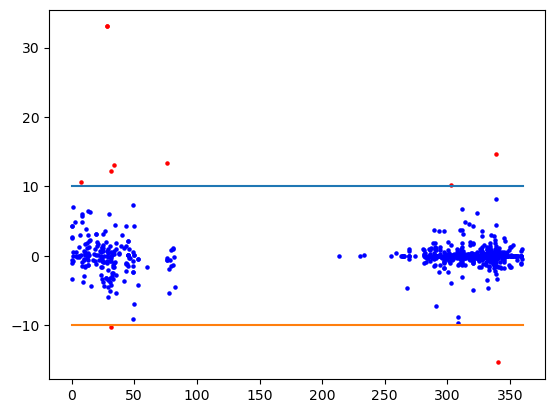

In [26]:
########################## Compare old vs new ############################################3
WISE_V23_df = pd.read_csv('/Users/loren/papers/wise/wise_hii_V2.3_hrds.csv')

# Merging on different column names
dfmerged = pd.merge(WISE_V23_df, WISE_Matched_df, on='GName', how='left')
dfmerged['VLSR'] = pd.to_numeric(dfmerged['VLSR_x'], errors='coerce')

# determine where new values are "difference" km/s from old ones, or there is now a value where there wasn't before, or vise-versa
difference = 10
for i in range(len(dfmerged)):
    # Disregard multiple velocity sources and only include those with detections
    if (dfmerged['VLSR_y'][i]>-230) & (dfmerged['VLSR2'][i]!=dfmerged['VLSR2'][i]) & (dfmerged['Year'][i]>=2021):
        if (np.abs(dfmerged['VLSR'][i] - dfmerged['VLSR_y'][i]) > difference) or ((dfmerged['VLSR_x'][i]!=dfmerged['VLSR_x'][i]) or (dfmerged['VLSR_y'][i]!=dfmerged['VLSR_y'][i])):
            print(dfmerged['Name_x'][i], dfmerged['VLSR_x'][i], dfmerged['Author_x'][i], 
                  dfmerged['Name_y'][i], dfmerged['VLSR_y'][i], dfmerged['Author_y'][i], i)
            plt.scatter(dfmerged['GLong_x'][i], dfmerged['VLSR'][i] - dfmerged['VLSR_y'][i],s=5, c='r')
        else:
            plt.scatter(dfmerged['GLong_x'][i], dfmerged['VLSR'][i] - dfmerged['VLSR_y'][i],s=5, c='b')
plt.plot([0, 360], [difference, difference])
plt.plot([0, 360], [-difference, -difference])


# check - removed erroneous old positions
# TW044  8.5  Anderson et al. (2015b) G76.187+0.098;TW044 -4.81 Khan et al. (2024) 3613
# ATCA802  -72.7  Anderson et al. (2015b) ATCA802;G340.247-00.373 -57.3 Wenger et al. (2021) 7203
# ATCA810  -39.9  Anderson et al. (2015b) ATCA810;G342.438-00.061 -4.2 Wenger et al. (2021) 7324
# Different sources - fixed
#G302.504-00.749  31.0  Caswell & Haynes (1987) G302.481-00.035 -41.6 Wenger et al. (2021) 5510
# original position in between two.  Khan position better.  Removed G028.295-00.377
#G028.295-00.377  76.9  Anderson et al. (2015a) G28.287-0.364;G028.295-00.377 43.85 Khan et al. (2024) 1791
# seems fine
# G031.275+00.056  104.7  Lockman (1989) G31.279+0.063;G031.275+00.056 115.05 Khan et al. (2024) 2143
# G033.418-00.004  76.5  Lockman (1989) G33.419-0.004;G033.418-00.004 63.49 Khan et al. (2024) 2275
#FA099  11.1  Anderson et al. (2011) G7.177+0.088;FA099 0.49 Khan et al. (2024) 418
# presumably better associations now
#G338.450+00.061  -43.7000  Wenger et al. (2021) G338.450+00.061;G338.364-00.020;G338.430+00.048 -56.1 Wenger et al. (2021) 7072
# GS003; SHRDS1241  -130.200  Wenger et al. (2021) GS003;SHRDS1241;G343.353-00.068;G343.352-00.081 -23.8 Wenger et al. (2021) 7361
#   -24.5000  Wenger et al. (2021) G345.486+00.399;G345.338+01.442;G345.486+00.399 -8.3 Wenger et al. (2021) 7458

In [27]:
############### Determine if any associated sources are outside the region ##############################
distance = ((WISE_Matched_df['GLong']-WISE_Matched_df['GLong_Observed'])**2 + (WISE_Matched_df['GLat']-WISE_Matched_df['GLat_Observed'])**2)**0.5
distance[distance!=distance]=0
wh = np.where(((distance*3600.) > ((WISE_Matched_df['Radius']**2)+(WISE_Matched_df['Resolution']*60.)**2)**0.5) & np.isfinite(WISE_Matched_df['GLong_Observed']))[0]
print(WISE_Matched_df.loc[wh, ['GName', 'Name_Observed', 'GLong_Observed', 'GLat_Observed', 'Author']], distance[wh])

                GName  Name_Observed  GLong_Observed  GLat_Observed                         Author
2945  G045.118+00.144  G45.122+0.131        45.12200        0.13100             Khan et al. (2024)
2949  G045.131+00.127  G45.122+0.131        45.12200        0.13100             Khan et al. (2024)
2951  G045.133+00.132  G45.132+0.143        45.13200        0.14300             Khan et al. (2024)
4663  G206.466-16.349           S277       206.89286      -16.81918  Fich, Dahl, & Treffers (1990)
4678  G208.921-19.268           OriA       209.01100      -19.38400           Balser et al. (2011) 2945    0.013735
2949    0.010040
2951    0.010128
4663    0.635190
4678    0.146820
dtype: float64


In [28]:
################################## Numbers ##############################################
n = len(WISE_Matched_df)

n_known = np.sum(WISE_Matched_df['Catalog'] == 'K')
n_group = np.sum(WISE_Matched_df['Catalog'] == 'G')
n_observe = np.sum(WISE_Matched_df['Catalog'] == 'C')
n_no_radio = np.sum(WISE_Matched_df['Catalog'] == 'Q')
print(n, n_known+n_group+n_observe+n_no_radio, n_known, n_group, n_observe, n_no_radio)

n = len(WISE_V23_df)
n_known = np.sum(WISE_V23_df['Catalog'] == ' K')
n_group = np.sum(WISE_V23_df['Catalog'] == ' G')
n_observe = np.sum(WISE_V23_df['Catalog'] == ' C')
n_no_radio = np.sum(WISE_V23_df['Catalog'] == ' Q')
print(n, n_known+n_group+n_observe+n_no_radio, n_known, n_group, n_observe, n_no_radio)

merged_df = pd.merge(WISE_Matched_df, WISE_V23_df, on='GName', how='inner')
#print(merged_df.head(10))

diff_rows = merged_df.loc[(merged_df['Catalog_x'] != 'known') & (merged_df['Catalog_y']==' K')]
cols = ['VLSR_x', 'Author_x', 'VLSR_y', 'Author_y']
print(diff_rows[cols])

diff_rows = merged_df.loc[(merged_df['Catalog_y'] != 'known') & (merged_df['Catalog_x']==' K')]
cols = ['VLSR_x', 'Author_x', 'VLSR_y', 'Author_y']
print(diff_rows[cols])

8589 8589 2530 730 3255 2074
8416 8415 2375 635 1687 3718
       VLSR_x                          Author_x                         VLSR_y                             Author_y
2         NaN                               NaN                      7.5;-12.1               Anderson et al. (2017)
13     15.500            Anderson et al. (2017)                           15.5               Anderson et al. (2017)
28     20.990                Khan et al. (2024)                           20.0                 Downes et al. (1980)
30        NaN                               NaN                            9.6        Fich  Dahl  & Treffers (1990)
31        NaN                               NaN                            9.6        Fich  Dahl  & Treffers (1990)
34      9.600     Fich, Dahl, & Treffers (1990)                                                                    
35        NaN                               NaN                                                                    
37     11.330 

# Now, let's create a SQL database from the DataFrame

In [29]:
WISE_Matched_df0 = WISE_Matched_df.copy()
db_file = f'/Users/loren/papers/wise/python/WISE_HII_V{str_version}.db'
conn = sqlite3.connect(db_file)

# Convert object columns to strings (this will handle most non-numeric data)
for col in WISE_Matched_df0.select_dtypes(include='object').columns:
    WISE_Matched_df0[col] = WISE_Matched_df0[col].astype(str)
    
# Write the DataFrame to the SQLite database as a new table
table_name = f'WISE_HII_V{str_version}.db'
WISE_Matched_df0.to_sql(table_name, conn, if_exists='replace', index=False)

# Commit and close the connection to the database
conn.commit()
conn.close()

# Save the DataFrame to a pkl and csv file too
WISE_Matched_df.to_pickle(f"{dir_path}WISE_HII_V{str_version}.pkl")
WISE_Matched_df.to_csv(f"{dir_path}WISE_HII_V{str_version}.csv", index=False)

In [35]:
cols = WISE_Matched_df.columns
for col in cols:
    print(col)

Catalog
GLong
GLat
Radius
Comments
Group_Flag
Group
Name
Alias
Simbad_comments
VGPSExclude
MagpisExclude
Parallax_Name
Magpis
NVSS
Cornish
Yusef20cmGC
LangRadio
LangPaschen
THOR
SMGPS
MeerKATGC
GName
RA (J2000)
Dec (J2000)
Name_Split
Name_Observed
GName_Observed
GLong_Observed
GLat_Observed
RA (J2000)_Observed
Dec (J2000)_Observed
TL
e_TL
FWHM
e_FWHM
VLSR
e_VLSR
VLSR_He
e_VLSR_He
FWHM_He
e_FWHM_He
TL_He
e_TL_He
VLSR_C
e_VLSR_C
FWHM_C
e_FWHM_C
TL_C
e_TL_C
Telescope
Resolution
Wavelength
Frequency
Author
Year
VLSR2
e_VLSR2
FWHM2
e_FWHM2
TL2
e_TL2
VLSR3
e_VLSR3
FWHM3
e_FWHM3
TL3
e_TL3
VLSR4
e_VLSR4
FWHM4
e_FWHM4
TL4
e_TL4
Name_Split_Observed
Name_Te
GName_Te
GLong_Te
GLat_Te
RA (J2000)_Te
Dec (J2000)_Te
Author_Te
Year_Te
Te
e_Te
y
e_y
Name_Split_Te
Name_Real_VLSR
GName_Real_VLSR
GLong_Real_VLSR
GLat_Real_VLSR
RA (J2000)_Real_VLSR
Dec (J2000)_Real_VLSR
Author_Real_VLSR
Year_Real_VLSR
Real_VLSR
Name_Split_Real_VLSR
Name_KDAR
GName_KDAR
GLong_KDAR
GLat_KDAR
RA (J2000)_KDAR
Dec (J2000)_KDAR
A

# Unneeded (but useful) code

In [ ]:
##################################  Allows us to do name substitutions #################################    
valid_names = ['G32.80+0.19',
'G33.13-0.09',
'G33.92+0.11',
'G34.26+0.15',
'G35.20-1.74',
'G35.57-0.03',
'G35.58+0.07',
'G41.74+0.10',
'G43.89-0.78',
'G45.07+0.13',
'G45.12+0.13',
'G45.45+0.06',
'G45.47+0.05',
'G48.61+0.02',
'G50.32+0.68',
'G60.88-0.13',
'G61.48+0.09',
'G70.29+1.60',
'G70.33+1.59',
'G10.16-0.35',
'G10.31-0.15',
'G10.46+0.03',
'G10.96+0.02',
'G11.11-0.40',
'G11.93-0.61',
'G12.41+0.51',
'G12.63-0.02',
'G12.68+0.01',
'G12.78+0.33',
'G12.91-0.26',
'G13.13-0.15',
'G13.88+0.28',
'G14.22-0.53',
'G14.33-0.64',
'G14.68-0.50',
'G16.58-0.05',
'G17.64+0.15',
'G18.46-0.00',
'G18.66-0.06',
'G19.07-0.28',
'G19.12-0.34',
'G19.36-0.02',
'G19.60-0.90',
'G19.88-0.53',
'G21.44-0.56',
'G21.87+0.01',
'G22.36+0.06',
'G23.20-0.00',
'G23.24-0.24',
'G23.27+0.08',
'G23.43-0.21',
'G23.71-0.20',
'G24.40-0.19',
'G24.50-0.06',
'G24.51-0.22',
'G24.68-0.16',
'G24.75-0.20',
'G25.16+0.06',
'G25.46-0.21',
'G25.79-0.14',
'G25.80+0.24',
'G26.51+0.28',
'G26.60-0.02',
'G27.19-0.08',
'G27.98+0.08',
'G28.20-0.05',
'G28.25+0.01',
'G28.60-0.36',
'G28.61+0.02',
'G28.86+0.06',
'G29.96-0.02',
'G30.38-0.11',
'G30.42+0.46',
'G30.82+0.27',
'G30.84-0.11',
'G30.87+0.11',
'G31.07+0.05',
'G31.41+0.31',
'G37.76-0.20',
'G37.87-0.40',
'G49.21-0.35',
'G345.49+0.31',
'G348.23-0.97',
'G349.83-0.53',
'G32.11+0.09',
'G32.15+0.13',
'G32.99+0.04',
'G33.20-0.01',
'G33.81-0.19',
'G34.09+0.44',
'G33.24+0.01',
'G34.40+0.23',
'G35.03+0.34',
'G35.04-0.50',
'G35.47+0.14',
'G35.58-0.03',
'G35.67-0.04',
'G36.40+0.02',
'G37.20-0.43',
'G37.37-0.24',
'G37.54-0.11',
'G37.75-0.10',
'G39.25-0.07',
'G40.42+0.70',
'G42.11-0.44',
'G42.43-0.26',
'G43.17+0.00',
'G43.18-0.52',
'G43.24-0.05',
'G43.79-0.12',
'G45.48+0.18',
'G45.82-0.29',
'G45.93-0.40',
'G48.63+0.23',
'G49.67-0.45',
'G50.28-0.39',
'G50.31+0.67',
'G52.23+0.74',
'G53.63+0.02',
'G54.09-0.06',
'G57.55-0.27',
'G58.77+0.65',
'G59.36-0.21',
'G59.60+0.92',
'G63.05-0.34',
'G63.12+0.44']

search_names = ['G032.800+00.190',
'G033.130-00.090',
'G033.920+00.110',
'G034.260+00.150',
'G035.200-01.740',
'G035.570-00.030',
'G035.580+00.070',
'G041.740+00.100',
'G043.890-00.780',
'G045.070+00.130',
'G045.120+00.130',
'G045.450+00.060',
'G045.470+00.050',
'G048.610+00.020',
'G050.320+00.680',
'G060.880-00.130',
'G061.480+00.090',
'G070.290+01.600',
'G070.330+01.590',
'G010.160-00.350',
'G010.310-00.150',
'G010.460+00.030',
'G010.960+00.020',
'G011.110-00.400',
'G011.930-00.610',
'G012.410+00.510',
'G012.630-00.020',
'G012.680+00.010',
'G012.780+00.330',
'G012.910-00.260',
'G013.130-00.150',
'G013.880+00.280',
'G014.220-00.530',
'G014.330-00.640',
'G014.680-00.500',
'G016.580-00.050',
'G017.640+00.150',
'G018.460-00.000',
'G018.660-00.060',
'G019.070-00.280',
'G019.120-00.340',
'G019.360-00.020',
'G019.600-00.900',
'G019.880-00.530',
'G021.440-00.560',
'G021.870+00.010',
'G022.360+00.060',
'G023.200-00.000',
'G023.240-00.240',
'G023.270+00.080',
'G023.430-00.210',
'G023.710-00.200',
'G024.400-00.190',
'G024.500-00.060',
'G024.510-00.220',
'G024.680-00.160',
'G024.750-00.200',
'G025.160+00.060',
'G025.460-00.210',
'G025.790-00.140',
'G025.800+00.240',
'G026.510+00.280',
'G026.600-00.020',
'G027.190-00.080',
'G027.980+00.080',
'G028.200-00.050',
'G028.250+00.010',
'G028.600-00.360',
'G028.610+00.020',
'G028.860+00.060',
'G029.960-00.020',
'G030.380-00.110',
'G030.420+00.460',
'G030.820+00.270',
'G030.840-00.110',
'G030.870+00.110',
'G031.070+00.050',
'G031.410+00.310',
'G037.760-00.200',
'G037.870-00.400',
'G049.210-00.350',
'G345.490+00.310',
'G348.230-00.970',
'G349.830-00.530',
'G032.110+00.090',
'G032.150+00.130',
'G032.990+00.040',
'G033.200-00.010',
'G033.810-00.190',
'G034.090+00.440',
'G033.240+00.010',
'G034.400+00.230',
'G035.030+00.340',
'G035.040-00.500',
'G035.470+00.140',
'G035.580-00.030',
'G035.670-00.040',
'G036.400+00.020',
'G037.200-00.430',
'G037.370-00.240',
'G037.540-00.110',
'G037.750-00.100',
'G039.250-00.070',
'G040.420+00.700',
'G042.110-00.440',
'G042.430-00.260',
'G043.170+00.000',
'G043.180-00.520',
'G043.240-00.050',
'G043.790-00.120',
'G045.480+00.180',
'G045.820-00.290',
'G045.930-00.400',
'G048.630+00.230',
'G049.670-00.450',
'G050.280-00.390',
'G050.310+00.670',
'G052.230+00.740',
'G053.630+00.020',
'G054.090-00.060',
'G057.550-00.270',
'G058.770+00.650',
'G059.360-00.210',
'G059.600+00.920',
'G063.050-00.340',
'G063.120+00.440']

# Create a dictionary that maps search names to valid names for substitution
name_mapping = dict(zip(search_names, valid_names))

# Read the CSV into a DataFrame
df = pd.read_csv('/Users/loren/papers/wise/wise_hii_master_V3.0.csv')

# Function to substitute names in the 'Name' column based on the mapping
def substitute_names(name, name_mapping):
    # Ensure that the name is a string (if it's not, return as is)
    if not isinstance(name, str):
        return name
    
    # For each name in the mapping, replace it in the string if found
    for search_name, valid_name in name_mapping.items():
        # If search_name exists in the current name, replace it with valid_name
        if search_name in name:
            name = name.replace(search_name, valid_name)
    return name

# Apply the substitution function to the 'Name' column
df['Name'] = df['Name'].apply(substitute_names, name_mapping=name_mapping)
df['Group'] = df['Group'].apply(substitute_names, name_mapping=name_mapping)

df.to_csv('/Users/loren/papers/wise/modified_file.csv', index=False)

print("File processed and saved as '/Users/loren/papers/wise/modified_file.csv'")

In [91]:
# deal with shrds
shrds_df = pd.read_pickle('/Users/loren/catalogs/shrds/shrds.pkl')
shrds_df = shrds_df.map(lambda x: x.value if isinstance(x, u.Quantity) else x)
shrds_df
df, unmatched = match_by_distance(WISE_df, shrds_df, size=WISE_df['Radius']/3600., extension='SHRDS', order_by='Year')
df['GName_SHRDS'] = df['GName_SHRDS'].fillna('')

non_unique_non_empty = df[df['GName_SHRDS'] != '']  # Filter out empty strings
non_unique_non_empty = non_unique_non_empty[non_unique_non_empty['GName_SHRDS'].duplicated(keep=False)]

for i, row in non_unique_non_empty.iterrows():
    print(i+2, row['Catalog'], row['GLong'], row['Radius'], row['GName_SHRDS'], row['Match_Distance'], row['GLong_SHRDS'], row['GLat_SHRDS'])


,Catalog,GLong,GLat,Radius,Comments,Group_Flag,Group,Name,Alias,Simbad_comments,...,NVSS,Cornish,Yusef20cmGC,LangRadio,LangPaschen,THOR,SMGPS,MeerKATGC,Unnamed: 22,Unnamed: 23
0,sharpless,0.003510,0.127687,206.696,NaN,0,NaN,S17;RCW138,NaN,NaN,...,0,0,0,0,0,0,0,1,NaN,NaN
1,observe,0.008924,0.036389,24.9627,NaN,0,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,1,NaN,NaN
2,known,0.020595,0.262560,444.387,NaN,0,S17;RCW138,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,NaN,NaN
3,no_radio,0.025792,-0.231194,46.2579,NaN,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,NaN,NaN
4,no_radio,0.029622,-0.089272,31.5545,NaN,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8584,observe,359.981000,-0.074288,17.7116,NaN,0,NaN,NaN,NaN,NaN,...,0,0,0,1,1,0,0,1,NaN,NaN
8585,no_radio,359.984000,-0.700351,72.9236,NaN,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,NaN,NaN
8586,observe,359.985000,0.027881,26.5407,NaN,0,NaN,G359.985+0.028,NaN,NaN,...,0,0,1,0,0,0,0,1,NaN,NaN
8587,observe,359.990000,0.012779,28.2032,NaN,0,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,1,NaN,NaN


In [ ]:
# Drop the table if it exists to avoid the duplicate column issue
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS RRL_Surveys")  # Drop the table to avoid conflict
conn.commit()

# Define the schema for the table based on the cleaned dataframe columns
columns = RRL_Surveys_df.columns.tolist()
column_definitions = ', '.join([f'"{col}" TEXT' if RRL_Surveys_df[col].dtype == 'object' else f'"{col}" REAL' for col in columns])

# Create the table with the defined schema
create_table_query = f"""
CREATE TABLE IF NOT EXISTS RRL_Surveys (
    {column_definitions}
);
"""
cursor.execute(create_table_query)
conn.commit()

# Insert the data from the cleaned DataFrame manually
for row in RRL_Surveys_df.itertuples(index=False, name=None):
    placeholders = ', '.join(['?'] * len(row))  # Generate correct number of placeholders
    insert_query = f"""
    INSERT INTO RRL_Surveys ({', '.join([f'"{col}"' for col in columns])})
    VALUES ({placeholders});
    """
    cursor.execute(insert_query, row)

conn.commit()

# Close the database connection
conn.close()

print("Database populated successfully!")